**Loading and transforming the Brain Tumor Dataset**

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
directory = "/content/gdrive/MyDrive/BrainTumorDataset"
# directory = "../dataset/original/BrainTumorDataset"

In [ ]:
def load_data(directory, extension):
  mat_files = []
  files = os.listdir(directory)
  count_files = 0

  for i, file in enumerate(files, start=1):
    if i % 10 == 0:
      sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'.format(i, len(files), i / float(len(files)) * 100))
      sys.stdout.flush()
    
    mat_file = h5py.File(os.path.join(directory,file),"r")
    mat_files.append(mat_file)
    count_files += 1

  print('\nTotal files read: ', count_files)
  return mat_files

In [ ]:
mat_files = load_data(directory, ".mat")

[3060/3064] images loaded: 99.9 %
Total files read:  3064


In [ ]:
first_file = mat_files[0]
print(first_file.keys())
print(first_file['cjdata']['image'])
print(first_file['cjdata']['label'])
print('Label:', int(first_file['cjdata']['label'][()]))

<KeysViewHDF5 ['cjdata']>
<HDF5 dataset "image": shape (512, 512), type "<i2">
<HDF5 dataset "label": shape (1, 1), type "<f8">
Label: 2


In [ ]:
def transform_data(mat_files, image_dimension):
  images = []
  labels = []
  for i, mat_file in enumerate(mat_files, start=1):
    image = cv2.resize(mat_file['cjdata']['image'][()], dsize=(image_dimension, image_dimension), 
                       interpolation = cv2.INTER_AREA)
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    label = int(mat_file['cjdata']['label'][()]) - 1
    images.append(image)
    labels.append(label)
    sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'.format(i, len(mat_files), i / float(len(mat_files)) * 100))
    sys.stdout.flush()

  images = np.array(images)
  labels = np.array(labels)
  print('\nimages:', images.shape)
  print('labels:', labels.shape)

  return images, labels   

In [ ]:
images, labels = transform_data(mat_files, 128)

[3064/3064] images loaded: 100.0 %
images: (3064, 128, 128)
labels: (3064,)


**Data Analysis and Visualisation**

number of 0: meningioma: 708
number of 1: glioma: 1426
number of 2: pituitary tumor: 930


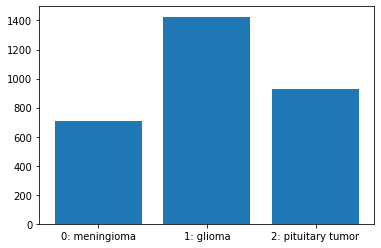

In [ ]:
integer_to_class = {'0': '0: meningioma', '1': '1: glioma', '2': '2: pituitary tumor'}
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, tick_label=['0: meningioma', '1: glioma', '2: pituitary tumor'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

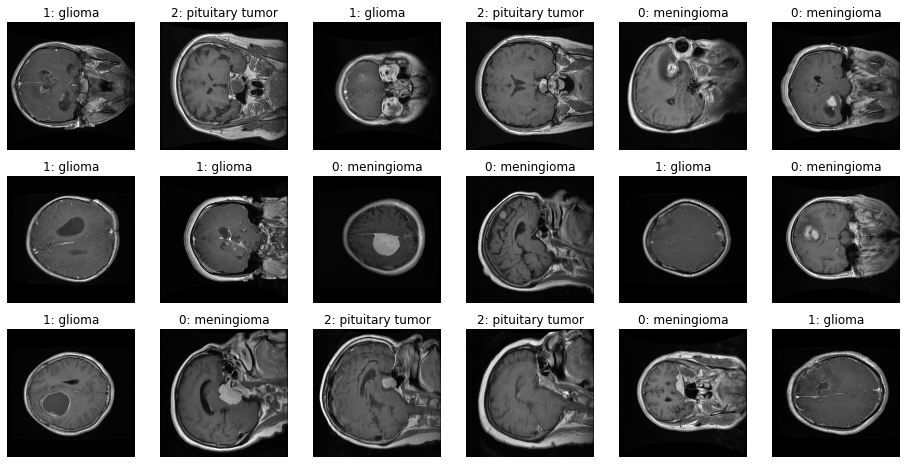

In [ ]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

**Data Augmentation**

In [ ]:
from scipy import ndimage

def rotate_45(image):
    
    return ndimage.rotate(image, 45, reshape = False)

In [ ]:
rotated_images = []

for image in images:
    rotated_images.append(rotate_45(image))

rotated_images = np.array(rotated_images)

In [ ]:
import random

def flip_up_down(image):
    
    return np.flipud(image)

In [ ]:
flipped_ud_images = []

for image in images:
    flipped_ud_images.append(flip_up_down(image))

flipped_ud_images = np.array(flipped_ud_images)

In [ ]:
def mirror_left_right(image):
    
    return np.fliplr(image)

In [ ]:
mirrored_lr_images = []

for image in images:
    mirrored_lr_images.append(mirror_left_right(image))

mirrored_lr_images = np.array(mirrored_lr_images)

In [ ]:
def salt_noise(image, prob):
    
    # Add salt noise to image
    # prob: Probability of the noise
    
    output = image.copy()
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            
            rdn = random.random()
            
            if rdn < prob:
                output[i][j] = 255
           
    return output

In [ ]:
noisy_images = []
prob = 0.01

for image in images:
    noisy_images.append(salt_noise(image, prob))

noisy_images = np.array(noisy_images)

**Visualisation of an origial, rotated, flipped, mirrored and salted image**

(-0.5, 127.5, 127.5, -0.5)

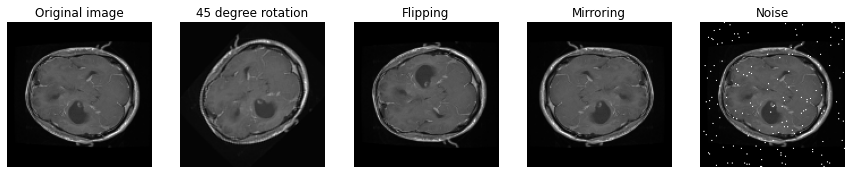

In [ ]:
rows = 1
columns = 5
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(rows, columns, 1)
plt.imshow(images[0], cmap='gray')
plt.title('Original image')
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(rotated_images[0], cmap='gray')
plt.title('45 degree rotation')
plt.axis('off')

fig.add_subplot(rows,columns, 3)
plt.imshow(flipped_ud_images[0], cmap='gray')
plt.title('Flipping')
plt.axis('off')

fig.add_subplot(rows,columns,4)
plt.imshow(mirrored_lr_images[0], cmap='gray')
plt.title('Mirroring')
plt.axis('off')

fig.add_subplot(rows,columns,5)
plt.imshow(noisy_images[0], cmap='gray')
plt.title('Noise')
plt.axis('off')


**Save Images**

In [ ]:
print('original labels shape: ', labels.shape)
labels = np.tile(labels,5)
print('labels shape after augmentation:', labels.shape)

original labels shape:  (3064,)
labels shape after augmentation: (15320,)


In [ ]:
print('original images shape: ', images.shape)
all_images = (images, rotated_images, flipped_ud_images, mirrored_lr_images, noisy_images)
all_images = np.concatenate(all_images)
print('images shape after augmentation:', all_images.shape)

original images shape:  (3064, 128, 128)
images shape after augmentation: (15320, 128, 128)


In [ ]:
# images_path = '../dataset/augmented_images.npz'
images_path = '/content/gdrive/MyDrive/augmented_images.npz'

In [ ]:
np.savez_compressed(images_path, images = all_images, labels = labels)

**Read Images**

In [ ]:
with np.load(images_path) as data:
    
  images = data['images']
  labels = data['labels']

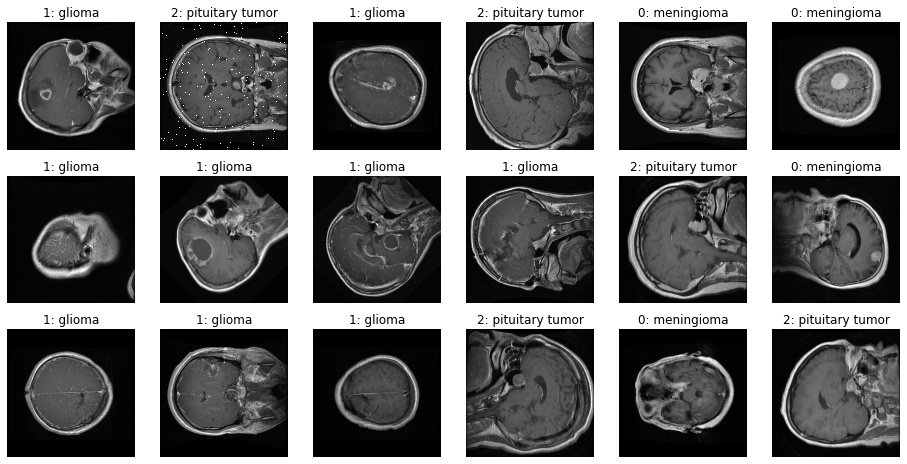

In [ ]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')